# Naive Bayes with Bag of Words and TFIDF

### Importing the necessary libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.stem.wordnet import WordNetLemmatizer
import pickle

from tqdm import tqdm
import os

### Importing the dataset

In [2]:
df = pd.read_csv('preprocessed_data.csv')

In [3]:
df.head(3)

,Unnamed: 0,Rev_id,Retailer,Division,Category,Department,Product_URL,Brand,Final_Price_after_Discount,Review_Link,Review_Creation_Date,Review_Rating_Score,preprocessed_review_text,preprocessed_product_name,preprocessed_review_header
0,0,1,Homedepot,lighting,ceiling_fans,ceiling_fans_with_lights,https://www.homedepot.com/p/Hampton-Bay-Rockpo...,hampton_bay,69.97,https://www.homedepot.com/ReviewServices/revie...,2018-04-24,1,excellent fan excellent price,rockport_52_led_brushed_nickel_ceiling_fan_lig...,excellent fan excellent price
1,1,2,Homedepot,lighting,ceiling_fans,ceiling_fans_with_lights,https://www.homedepot.com/p/Hampton-Bay-Rockpo...,hampton_bay,69.97,https://www.homedepot.com/ReviewServices/revie...,2019-10-15,1,put fans spec houses everyone likes like price...,rockport_52_led_brushed_nickel_ceiling_fan_lig...,put fans spec houses everyone
2,2,3,Homedepot,lighting,ceiling_fans,ceiling_fans_with_lights,https://www.homedepot.com/p/Hampton-Bay-Rockpo...,hampton_bay,69.97,https://www.homedepot.com/ReviewServices/revie...,2019-07-03,1,rating provided verified purchaser,rockport_52_led_brushed_nickel_ceiling_fan_lig...,5 star review


In [4]:
# dropping the column Unnamed: 0 which was created during saving the file
df=df.drop(columns={'Unnamed: 0'})

In [5]:
df.head(1)

,Rev_id,Retailer,Division,Category,Department,Product_URL,Brand,Final_Price_after_Discount,Review_Link,Review_Creation_Date,Review_Rating_Score,preprocessed_review_text,preprocessed_product_name,preprocessed_review_header
0,1,Homedepot,lighting,ceiling_fans,ceiling_fans_with_lights,https://www.homedepot.com/p/Hampton-Bay-Rockpo...,hampton_bay,69.97,https://www.homedepot.com/ReviewServices/revie...,2018-04-24,1,excellent fan excellent price,rockport_52_led_brushed_nickel_ceiling_fan_lig...,excellent fan excellent price


## Calculating sentiment scores of review text using nltk

In [6]:
# Importing nltk and SentimentIntensityAnalyzer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [7]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\chanchal\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [8]:
# Initalizing SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [9]:
# Storing essay from the dataframe in a variable 'essay'
preprocessed_review_text = df['preprocessed_review_text']

In [10]:
# Getting polarity scores for each essay and storing it in a dictionary
scores_dict = df['preprocessed_review_text'].apply(lambda essay:sid.polarity_scores(str(essay)))

In [11]:
# Converting the dictionary to a dataframe, this will be used to merge with our main dataframe
df1=pd.DataFrame.from_records(scores_dict)

In [12]:
# Checking the head of the new dataframe
df1.head(1)

,neg,neu,pos,compound
0,0.0,0.093,0.907,0.8658


In [13]:
# Merging the main dataframe with the new dataframe
df=pd.merge(df, df1, left_index=True, right_index=True)

In [14]:
# The dataframe that will be used in our further analysis
df.head(1)

,Rev_id,Retailer,Division,Category,Department,Product_URL,Brand,Final_Price_after_Discount,Review_Link,Review_Creation_Date,Review_Rating_Score,preprocessed_review_text,preprocessed_product_name,preprocessed_review_header,neg,neu,pos,compound
0,1,Homedepot,lighting,ceiling_fans,ceiling_fans_with_lights,https://www.homedepot.com/p/Hampton-Bay-Rockpo...,hampton_bay,69.97,https://www.homedepot.com/ReviewServices/revie...,2018-04-24,1,excellent fan excellent price,rockport_52_led_brushed_nickel_ceiling_fan_lig...,excellent fan excellent price,0.0,0.093,0.907,0.8658


### Splitting data into Train and Test: Stratified Sampling

In [15]:
# Segregating the dependent and independent variables as y and X respectively
y = df['Review_Rating_Score'].values
X = df.drop(['Review_Rating_Score'], axis=1)
X.head(1)

,Rev_id,Retailer,Division,Category,Department,Product_URL,Brand,Final_Price_after_Discount,Review_Link,Review_Creation_Date,preprocessed_review_text,preprocessed_product_name,preprocessed_review_header,neg,neu,pos,compound
0,1,Homedepot,lighting,ceiling_fans,ceiling_fans_with_lights,https://www.homedepot.com/p/Hampton-Bay-Rockpo...,hampton_bay,69.97,https://www.homedepot.com/ReviewServices/revie...,2018-04-24,excellent fan excellent price,rockport_52_led_brushed_nickel_ceiling_fan_lig...,excellent fan excellent price,0.0,0.093,0.907,0.8658


In [16]:
# Splitting the data into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [17]:
# Printing the shape of the data
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(841, 17) (841,)
(281, 17) (281,)


# Bag of Words

### Review Text

In [18]:
# Implementing Bag of Words
vectorizer_bow = CountVectorizer(min_df=5)

In [19]:
# Applying fit method on 'preprocessed_review_text' column
vectorizer_bow.fit(X_train['preprocessed_review_text'].values) # fit has to happen only on train data

CountVectorizer(min_df=5)

In [20]:
# Applying transform method on train and test set
X_train_review_text_bow = vectorizer_bow.transform(X_train['preprocessed_review_text'].values)

In [21]:
X_test_review_text_bow = vectorizer_bow.transform(X_test['preprocessed_review_text'].values)

In [22]:
# Shape of the data after vectorization
print("After vectorizations")
print(X_train_review_text_bow.shape, y_train.shape)
print(X_test_review_text_bow.shape, y_test.shape)

After vectorizations
(841, 589) (841,)
(281, 589) (281,)


In [23]:
X_train.head(2)

,Rev_id,Retailer,Division,Category,Department,Product_URL,Brand,Final_Price_after_Discount,Review_Link,Review_Creation_Date,preprocessed_review_text,preprocessed_product_name,preprocessed_review_header,neg,neu,pos,compound
694,730,Lowes,lighting_&_ceiling_fans,ceiling_fans_&_accessories,ceiling_fans,https://www.lowes.com/pd/Harbor-Breeze-Centrev...,harbor_breeze,49.98,https://www.lowes.com/pd/Harbor-Breeze-Centrev...,2019-10-14,fan much quiet one got rid love look furniture,harbor_breeze_centreville_52_antique_brass_led...,great large bedroom,0.0,0.519,0.481,0.7579
482,510,Homedepot,lighting,ceiling_fans,ceiling_fans_with_lights,https://www.homedepot.com/p/Home-Decorators-Co...,home_decorators_collection,99.97,https://www.homedepot.com/ReviewServices/revie...,2019-09-12,rating provided verified purchaser,merwry_52_integrated_led_indoor_white_ceiling_...,5 star review,0.0,1.000,0.000,0.0000


### Review_Header

In [24]:
# Implementing Bag of Words
vectorizer_bow_rh = CountVectorizer(min_df=5)

In [25]:
# Applying fit method on 'preprocessed_review_text' column
vectorizer_bow_rh.fit(X_train['preprocessed_review_header'].values) # fit has to happen only on train data

CountVectorizer(min_df=5)

In [26]:
# Applying transform method on train and test set
X_train_review_header_bow = vectorizer_bow_rh.transform(X_train['preprocessed_review_header'].values)

In [27]:
X_test_review_header_bow = vectorizer_bow_rh.transform(X_test['preprocessed_review_header'].values)

In [28]:
# Shape of the data after vectorization
print("After vectorizations")
print(X_train_review_header_bow.shape, y_train.shape)
print(X_test_review_header_bow.shape, y_test.shape)

After vectorizations
(841, 119) (841,)
(281, 119) (281,)


## Encoding Numerical and Categorical Features

#### Encoding Categorical Feature: Retailer

In [29]:
vectorizer_r = CountVectorizer()
vectorizer_r.fit(X_train['Retailer'].values) # fit method on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_retailer_ohe = vectorizer_r.transform(X_train['Retailer'].values)
X_test_retailer_ohe = vectorizer_r.transform(X_test['Retailer'].values)

print("After vectorizations")
print(X_train_retailer_ohe.shape, y_train.shape)
print(X_test_retailer_ohe.shape, y_test.shape)
print(vectorizer_r.get_feature_names())
print("="*100)

After vectorizations
(841, 2) (841,)
(281, 2) (281,)
['homedepot', 'lowes']


#### Encoding Categorical Feature: Division

In [30]:
vectorizer_d = CountVectorizer()
vectorizer_d.fit(X_train['Division'].values) # fit method on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_division_ohe = vectorizer_d.transform(X_train['Division'].values)
X_test_division_ohe = vectorizer_d.transform(X_test['Division'].values)

print("After vectorizations")
print(X_train_division_ohe.shape, y_train.shape)
print(X_test_division_ohe.shape, y_test.shape)
print(vectorizer_d.get_feature_names())
print("="*100)

After vectorizations
(841, 3) (841,)
(281, 3) (281,)
['_ceiling_fans', 'lighting', 'lighting_']


#### Encoding Categorical Feature: Category

In [31]:
vectorizer_c = CountVectorizer()
vectorizer_c.fit(X_train['Category'].values) # fit method on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_category_ohe = vectorizer_d.transform(X_train['Category'].values)
X_test_category_ohe = vectorizer_d.transform(X_test['Category'].values)

print("After vectorizations")
print(X_train_category_ohe.shape, y_train.shape)
print(X_test_category_ohe.shape, y_test.shape)
print(vectorizer_c.get_feature_names())
print("="*100)

After vectorizations
(841, 3) (841,)
(281, 3) (281,)
['_accessories', 'ceiling_fans', 'ceiling_fans_']


#### Encoding Categorical Feature: Department

In [32]:
vectorizer_de = CountVectorizer()
vectorizer_de.fit(X_train['Department'].values) # fit method on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_department_ohe = vectorizer_d.transform(X_train['Department'].values)
X_test_department_ohe = vectorizer_d.transform(X_test['Department'].values)

print("After vectorizations")
print(X_train_department_ohe.shape, y_train.shape)
print(X_test_department_ohe.shape, y_test.shape)
print(vectorizer_de.get_feature_names())
print("="*100)

After vectorizations
(841, 3) (841,)
(281, 3) (281,)
['ceiling_fans', 'ceiling_fans_with_lights', 'ceiling_fans_without_lights']


#### Encoding Categorical Feature: Brand

In [33]:
vectorizer_b = CountVectorizer()
vectorizer_b.fit(X_train['Brand'].values) # fit method on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_brand_ohe = vectorizer_d.transform(X_train['Brand'].values)
X_test_brand_ohe = vectorizer_d.transform(X_test['Brand'].values)

print("After vectorizations")
print(X_train_brand_ohe.shape, y_train.shape)
print(X_test_brand_ohe.shape, y_test.shape)
print(vectorizer_b.get_feature_names())
print("="*100)

After vectorizations
(841, 3) (841,)
(281, 3) (281,)
['brand_not_mentioned', 'fanimation_studio_collection', 'hampton_bay', 'harbor_breeze', 'home_decorators_collection', 'hunter', 'kichler']


#### Encoding Categorical Feature: preprocessed_product_name

In [34]:
vectorizer_pn = CountVectorizer()
vectorizer_pn.fit(X_train['preprocessed_product_name'].values) # fit method on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_pn_ohe = vectorizer_pn.transform(X_train['preprocessed_product_name'].values)
X_test_pn_ohe = vectorizer_pn.transform(X_test['preprocessed_product_name'].values)

print("After vectorizations")
print(X_train_pn_ohe.shape, y_train.shape)
print(X_test_pn_ohe.shape, y_test.shape)
print(vectorizer_pn.get_feature_names())
print("="*100)

After vectorizations
(841, 79) (841,)
(281, 79) (281,)
['altura_60_outdoor_oil_rubbed_bronze_ceiling_fan', 'altura_68_indoor_oil_rubbed_bronze_ceiling_fan_remote_control', 'antero_46_led_indoor_brushed_nickel_ceiling_fan_light', 'ashby_park_44_white_color_changing_integrated_led_brushed_nickel_ceiling_fan_light_kit', 'ashby_park_52_white_color_changing_integrated_led_brushed_nickel_ceiling_fan_light_kit_remote_control', 'barnes_bay_52_led_indoor_outdoor_natural_iron_ceiling_fan_light_kit', 'bellina_42_oil_rubbed_bronze_ceiling_fan_led_light_kit', 'brette_23_led_indoor_outdoor_brushed_nickel_ceiling_fan_light_kit_remote_control', 'brookhurst_52_led_indoor_white_ceiling_fan_light_kit', 'channelside_52_led_indoor_outdoor_noble_bronze_ceiling_fan_remote_control', 'channing_54_led_indoor_easy_install_noble_bronze_ceiling_fan_hunterexpress_feature_set', 'clarkston_ii_44_led_indoor_brushed_nickel_ceiling_fan_light_kit', 'connor_54_led_brushed_nickel_dual_mount_ceiling_fan_light_kit_remote_con

#### Encoding Numerical Feature: Price

In [35]:
from sklearn.preprocessing import Normalizer
normalizer_pr = Normalizer()

normalizer_pr.fit(X_train['Final_Price_after_Discount'].values.reshape(-1,1)) # Applying fit method on train data after reshaping the data

X_train_price_norm = normalizer_pr.transform(X_train['Final_Price_after_Discount'].values.reshape(-1,1)) # Applying transform method on train and test
X_test_price_norm = normalizer_pr.transform(X_test['Final_Price_after_Discount'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(841, 1) (841,)
(281, 1) (281,)


#### Encoding Numerical Feature: neg

In [36]:
from sklearn.preprocessing import Normalizer
normalizer_neg = Normalizer()

# Applying fit method on train data after reshaping the data
normalizer_neg.fit(X_train['neg'].values.reshape(-1,1))

# Applying transform method on train and test
X_train_neg_norm = normalizer_neg.transform(X_train['neg'].values.reshape(-1,1))
X_test_neg_norm = normalizer_neg.transform(X_test['neg'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_neg_norm.shape, y_train.shape)
print(X_test_neg_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(841, 1) (841,)
(281, 1) (281,)


#### Encoding Numerical Feature: neu

In [37]:
from sklearn.preprocessing import Normalizer
normalizer_neu = Normalizer()

# Applying fit method on train data after reshaping the data
normalizer_neu.fit(X_train['neu'].values.reshape(-1,1))

# Applying transform method on train and test
X_train_neu_norm = normalizer_neu.transform(X_train['neu'].values.reshape(-1,1))
X_test_neu_norm = normalizer_neu.transform(X_test['neu'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_neu_norm.shape, y_train.shape)
print(X_test_neu_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(841, 1) (841,)
(281, 1) (281,)


#### Encoding Numerical Feature: pos

In [38]:
from sklearn.preprocessing import Normalizer
normalizer_pos = Normalizer()

# Applying fit method on train data after reshaping the data
normalizer_pos.fit(X_train['pos'].values.reshape(-1,1))

# Applying transform method on train and test
X_train_pos_norm = normalizer_pos.transform(X_train['pos'].values.reshape(-1,1))
X_test_pos_norm = normalizer_pos.transform(X_test['pos'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_pos_norm.shape, y_train.shape)
print(X_test_pos_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(841, 1) (841,)
(281, 1) (281,)


#### Encoding Numerical Feature: compound

In [39]:
from sklearn.preprocessing import Normalizer
normalizer_com = Normalizer()

# Applying fit method on train data after reshaping the data
normalizer_com.fit(X_train['compound'].values.reshape(-1,1))

# Applying transform method on train and test
X_train_com_norm = normalizer_com.transform(X_train['compound'].values.reshape(-1,1))
X_test_com_norm = normalizer_com.transform(X_test['compound'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_com_norm.shape, y_train.shape)
print(X_test_com_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(841, 1) (841,)
(281, 1) (281,)


### Concatinating all the features

In [40]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_review_text_bow,X_train_review_header_bow, X_train_retailer_ohe, X_train_division_ohe,X_train_category_ohe,X_train_department_ohe,X_train_brand_ohe,X_train_pn_ohe,X_train_price_norm)).tocsr()
X_te = hstack((X_test_review_text_bow,X_test_review_header_bow, X_test_retailer_ohe, X_test_division_ohe,X_test_category_ohe,X_test_department_ohe,X_test_brand_ohe,X_test_pn_ohe,X_test_price_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(841, 802) (841,)
(281, 802) (281,)


### Applying Grid Search CV to find the best hyperparameter

In [41]:
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score

In [42]:
# Multinomial NB model with class_prior [.5,.5] and a dictionary containing the list of alpha values to test for.
mnb = MultinomialNB(class_prior=[.5,.5])
parameters = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}

In [43]:
# Applying GridSearchCV to find the best parameter, here we have chosen 4 fold cross validation
clf = GridSearchCV(mnb, parameters, cv=4, scoring='roc_auc',return_train_score=True)
clf.fit(X_tr, y_train)

GridSearchCV(cv=4, estimator=MultinomialNB(class_prior=[0.5, 0.5]),
             param_grid={'alpha': [1e-05, 0.0005, 0.0001, 0.005, 0.001, 0.05,
                                   0.01, 0.1, 0.5, 1, 5, 10, 50, 100]},
             return_train_score=True, scoring='roc_auc')

In [44]:
# Let's store the results of CV in a pandas dataframe
results = pd.DataFrame.from_dict(clf.cv_results_)

In [45]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.003731,0.001774,0.003490,0.001651,1e-05,{'alpha': 1e-05},0.878708,0.801707,0.727335,0.853513,0.815316,0.057886,12,0.996926,0.996170,0.997171,0.997280,0.996886,0.000433
1,0.001486,0.000491,0.002003,0.000012,0.0005,{'alpha': 0.0005},0.920570,0.835361,0.792779,0.904042,0.863188,0.051705,10,0.996424,0.995364,0.996561,0.996365,0.996179,0.000476
2,0.001497,0.000499,0.001497,0.000500,0.0001,{'alpha': 0.0001},0.896175,0.816327,0.766778,0.884223,0.840876,0.052512,11,0.996686,0.995800,0.996910,0.996735,0.996533,0.000431
3,0.001497,0.000498,0.001487,0.000490,0.005,{'alpha': 0.005},0.951795,0.879121,0.833203,0.927786,0.897976,0.045652,7,0.995726,0.994624,0.995908,0.995234,0.995373,0.000498
4,0.001745,0.000433,0.001497,0.000499,0.001,{'alpha': 0.001},0.932084,0.846056,0.804258,0.911303,0.873425,0.051012,9,0.996250,0.995212,0.996474,0.996213,0.996037,0.000487
5,0.001497,0.000498,0.001744,0.000432,0.05,{'alpha': 0.05},0.963115,0.922488,0.885008,0.941327,0.927984,0.028676,4,0.993154,0.992404,0.993993,0.992448,0.993000,0.000646
6,0.001750,0.000434,0.001491,0.000493,0.01,{'alpha': 0.01},0.958236,0.899529,0.846154,0.933870,0.909447,0.042075,6,0.995443,0.994102,0.995669,0.994624,0.994960,0.000629
7,0.001505,0.000508,0.001497,0.000500,0.1,{'alpha': 0.1},0.962334,0.925628,0.911303,0.942896,0.935540,0.019090,3,0.991758,0.990750,0.992557,0.991360,0.991606,0.000656
8,0.001497,0.000499,0.001745,0.000431,0.5,{'alpha': 0.5},0.954528,0.928768,0.935832,0.934851,0.938495,0.009644,1,0.987027,0.984200,0.987595,0.986920,0.986435,0.001316
9,0.001496,0.000499,0.001497,0.000499,1,{'alpha': 1},0.951991,0.925235,0.936617,0.928768,0.935653,0.010293,2,0.983429,0.979934,0.983830,0.983373,0.982641,0.001573


In [46]:
# Let us sort values based of the param_alpha column which will sort values in ascending order of alpha
results = results.sort_values(['param_alpha'])

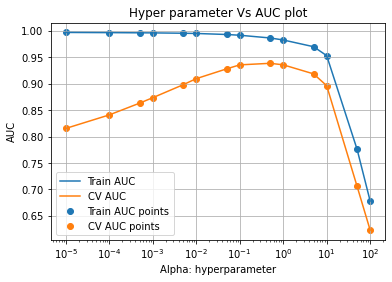

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.003731,0.001774,0.003490,0.001651,1e-05,{'alpha': 1e-05},0.878708,0.801707,0.727335,0.853513,0.815316,0.057886,12,0.996926,0.996170,0.997171,0.997280,0.996886,0.000433
2,0.001497,0.000499,0.001497,0.000500,0.0001,{'alpha': 0.0001},0.896175,0.816327,0.766778,0.884223,0.840876,0.052512,11,0.996686,0.995800,0.996910,0.996735,0.996533,0.000431
1,0.001486,0.000491,0.002003,0.000012,0.0005,{'alpha': 0.0005},0.920570,0.835361,0.792779,0.904042,0.863188,0.051705,10,0.996424,0.995364,0.996561,0.996365,0.996179,0.000476
4,0.001745,0.000433,0.001497,0.000499,0.001,{'alpha': 0.001},0.932084,0.846056,0.804258,0.911303,0.873425,0.051012,9,0.996250,0.995212,0.996474,0.996213,0.996037,0.000487
3,0.001497,0.000498,0.001487,0.000490,0.005,{'alpha': 0.005},0.951795,0.879121,0.833203,0.927786,0.897976,0.045652,7,0.995726,0.994624,0.995908,0.995234,0.995373,0.000498
6,0.001750,0.000434,0.001491,0.000493,0.01,{'alpha': 0.01},0.958236,0.899529,0.846154,0.933870,0.909447,0.042075,6,0.995443,0.994102,0.995669,0.994624,0.994960,0.000629
5,0.001497,0.000498,0.001744,0.000432,0.05,{'alpha': 0.05},0.963115,0.922488,0.885008,0.941327,0.927984,0.028676,4,0.993154,0.992404,0.993993,0.992448,0.993000,0.000646
7,0.001505,0.000508,0.001497,0.000500,0.1,{'alpha': 0.1},0.962334,0.925628,0.911303,0.942896,0.935540,0.019090,3,0.991758,0.990750,0.992557,0.991360,0.991606,0.000656
8,0.001497,0.000499,0.001745,0.000431,0.5,{'alpha': 0.5},0.954528,0.928768,0.935832,0.934851,0.938495,0.009644,1,0.987027,0.984200,0.987595,0.986920,0.986435,0.001316
9,0.001496,0.000499,0.001497,0.000499,1,{'alpha': 1},0.951991,0.925235,0.936617,0.928768,0.935653,0.010293,2,0.983429,0.979934,0.983830,0.983373,0.982641,0.001573


In [47]:
train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
alpha =  results['param_alpha']

plt.plot(alpha, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(alpha, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(alpha, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')

plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head(10)

In [48]:
best_alpha = .5

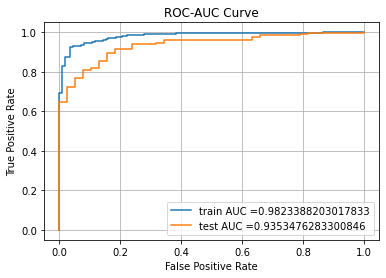

In [49]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc

# Hyper parameters : alpha = best_alpha and class_prior=[.5,.5]
mnb = MultinomialNB(alpha=best_alpha, class_prior=[.5,.5])
mnb.fit(X_tr, y_train)

y_train_pred = mnb.predict_proba(X_tr)[:,1]    
y_test_pred = mnb.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
#plt.xscale('log')
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.grid()
plt.show()

In [50]:
# we are writing our own function to predict, with defined thresold
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [51]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.8941798941798942 for threshold 0.678
Train confusion matrix
[[108   4]
 [ 53 676]]
Test confusion matrix
[[ 31   7]
 [ 24 219]]


In [52]:
cm_train=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
cm_test=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

Text(33.0, 0.5, 'Actual')

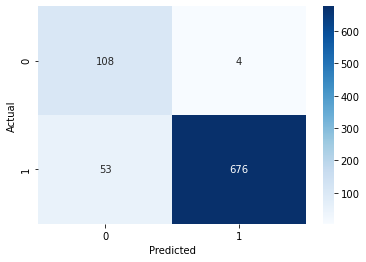

In [53]:
# Train Confusion Matrix
sns.heatmap(cm_train, annot=True,fmt="d",cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Text(33.0, 0.5, 'Actual')

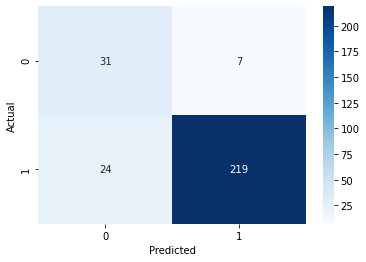

In [54]:
# Test Confusion Matrix
sns.heatmap(cm_test, annot=True,fmt="d",cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

### Top 20 features BOW

In [55]:
neg_class_prob_sorted = (mnb.feature_log_prob_[0, :]).argsort()
pos_class_prob_sorted = (mnb.feature_log_prob_[1, :]).argsort()

In [56]:
features=vectorizer_bow.get_feature_names()+vectorizer_bow_rh.get_feature_names()+vectorizer_r.get_feature_names()+vectorizer_d.get_feature_names()+vectorizer_c.get_feature_names()+vectorizer_de.get_feature_names()+vectorizer_b.get_feature_names()+vectorizer_pn.get_feature_names()+['Final_Price_after_Discount']

In [57]:
neg_class_features = np.take(features, neg_class_prob_sorted[:20])
pos_class_features = np.take(features, pos_class_prob_sorted[:20])

In [58]:
print("\nThe top 20 features from the positive class are :\n")
print(neg_class_features)

print("The top 20 features from the negative class are :\n")
print(pos_class_features)


The top 20 features from the positive class are :

['fanimation_studio_collection_prop_60_matte_gray_indoor_ceiling_fan_remote_3_blade'
 'hugger_52_led_indoor_brushed_nickel_ceiling_fan_light_kit' 'course'
 'wired' 'hawkins_44_led_oil_rubbed_bronze_ceiling_fan_light'
 'ceiling_fans' 'wife' '_accessories'
 'fanimation_studio_collection_weather_pylon_48_matte_black_led_indoor_outdoor_ceiling_fan_light_kit_remote_3_blade'
 'would' 'quite'
 'harbor_breeze_sailstream_44_gloss_white_led_indoor_flush_mount_ceiling_fan_light_kit_remote_3_blade'
 'difference' 'inch' 'video' 'dimmable' 'important' 'rustic' 'price'
 'cools']
The top 20 features from the negative class are :

['ceiling_fans_without_lights' 'hum' 'brand_not_mentioned'
 'ceiling_fans_with_lights' 'fanimation_studio_collection' 'ceiling_fans_'
 'horrible' 'told' 'ceiling_fans' 'horrible' 'ceiling_fans' 'poor'
 'hampton_bay' '_accessories' 'spinning' 'humming' 'smell' 'unfortunately'
 'impossible' 'canopy']


## TFIDF

### Review_Text

In [59]:
# Implementing TF-IDF
vectorizer_tfidf = TfidfVectorizer(min_df=5)
vectorizer_tfidf.fit(X_train['preprocessed_review_text'].values) #(Fit Method)

TfidfVectorizer(min_df=5)

In [60]:
# Transform method on train and test data
X_train_rt_tfidf = vectorizer_tfidf.transform(X_train['preprocessed_review_text'].values)

In [61]:
X_test_rt_tfidf = vectorizer_tfidf.transform(X_test['preprocessed_review_text'].values)

In [62]:
print("After vectorizations")
print(X_train_rt_tfidf.shape, y_train.shape)
print(X_test_rt_tfidf.shape, y_test.shape)

After vectorizations
(841, 589) (841,)
(281, 589) (281,)


### Review_Header

In [63]:
# Implementing TF-IDF
vectorizer_tfidf_rh = TfidfVectorizer(min_df=5)
vectorizer_tfidf_rh.fit(X_train['preprocessed_review_header'].values) #(Fit Method)

TfidfVectorizer(min_df=5)

In [64]:
# Transform method on train and test data
X_train_rh_tfidf = vectorizer_tfidf_rh.transform(X_train['preprocessed_review_header'].values)

In [65]:
X_test_rh_tfidf = vectorizer_tfidf_rh.transform(X_test['preprocessed_review_text'].values)

In [66]:
print("After vectorizations")
print(X_train_rh_tfidf.shape, y_train.shape)
print(X_test_rh_tfidf.shape, y_test.shape)

After vectorizations
(841, 119) (841,)
(281, 119) (281,)


### Concatinating all the features

In [67]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_rt_tfidf,X_train_rh_tfidf, X_train_retailer_ohe, X_train_division_ohe,X_train_category_ohe,X_train_department_ohe,X_train_brand_ohe,X_train_pn_ohe,X_train_price_norm )).tocsr()
X_te = hstack((X_test_rt_tfidf,X_test_rh_tfidf, X_test_retailer_ohe, X_test_division_ohe,X_test_category_ohe,X_test_department_ohe,X_test_brand_ohe,X_test_pn_ohe,X_test_price_norm)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(841, 802) (841,)
(281, 802) (281,)


In [68]:
# Multinomial NB model with class_prior [.5,.5] and a dictionary containing the list of alpha values to test for.
mnb = MultinomialNB(class_prior=[.5,.5])
parameters = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}

In [69]:
# Grid search CV using 4-fold CV and fitting the train and test data
clf = GridSearchCV(mnb, parameters, cv=4, scoring='roc_auc',return_train_score=True)
clf.fit(X_tr, y_train)

GridSearchCV(cv=4, estimator=MultinomialNB(class_prior=[0.5, 0.5]),
             param_grid={'alpha': [1e-05, 0.0005, 0.0001, 0.005, 0.001, 0.05,
                                   0.01, 0.1, 0.5, 1, 5, 10, 50, 100]},
             return_train_score=True, scoring='roc_auc')

In [70]:
clf.best_params_

{'alpha': 0.5}

In [71]:
# Sorting the values by param_alpha
results = results.sort_values(['param_alpha'])

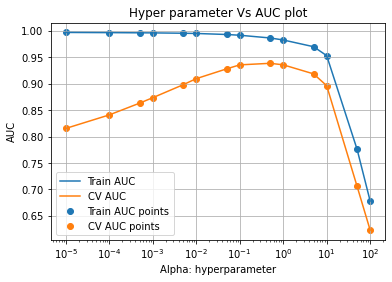

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.003731,0.001774,0.003490,0.001651,1e-05,{'alpha': 1e-05},0.878708,0.801707,0.727335,0.853513,0.815316,0.057886,12,0.996926,0.996170,0.997171,0.997280,0.996886,0.000433
2,0.001497,0.000499,0.001497,0.000500,0.0001,{'alpha': 0.0001},0.896175,0.816327,0.766778,0.884223,0.840876,0.052512,11,0.996686,0.995800,0.996910,0.996735,0.996533,0.000431
1,0.001486,0.000491,0.002003,0.000012,0.0005,{'alpha': 0.0005},0.920570,0.835361,0.792779,0.904042,0.863188,0.051705,10,0.996424,0.995364,0.996561,0.996365,0.996179,0.000476
4,0.001745,0.000433,0.001497,0.000499,0.001,{'alpha': 0.001},0.932084,0.846056,0.804258,0.911303,0.873425,0.051012,9,0.996250,0.995212,0.996474,0.996213,0.996037,0.000487
3,0.001497,0.000498,0.001487,0.000490,0.005,{'alpha': 0.005},0.951795,0.879121,0.833203,0.927786,0.897976,0.045652,7,0.995726,0.994624,0.995908,0.995234,0.995373,0.000498


In [72]:
train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
alpha =  results['param_alpha']

plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')


plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')

plt.xscale('log')
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")
plt.grid()
plt.show()

results.head()

In [73]:
best_alpha = .1

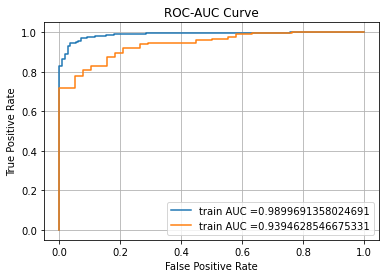

In [74]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


mnb = MultinomialNB(alpha=best_alpha, class_prior=[.5,.5])
mnb.fit(X_tr, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = mnb.predict_proba(X_tr)[:,1]    
y_test_pred = mnb.predict_proba(X_te)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.grid()
plt.show()

In [75]:
# we are writing our own function to predict, with defined threshold
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshold, fpr, tpr):
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [76]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))

the maximum value of tpr*(1-fpr) 0.9126984126984128 for threshold 0.351
Train confusion matrix
[[108   4]
 [ 39 690]]
Test confusion matrix
[[ 30   8]
 [ 26 217]]


In [77]:
cm_train=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
cm_test=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

Text(33.0, 0.5, 'Actual')

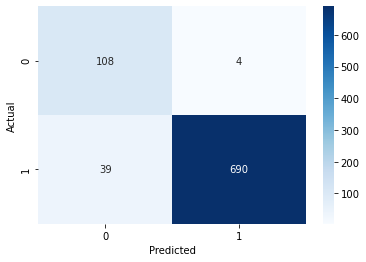

In [78]:
# Train Confusion Matrix
sns.heatmap(cm_train, annot=True,fmt="d",cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Text(33.0, 0.5, 'Actual')

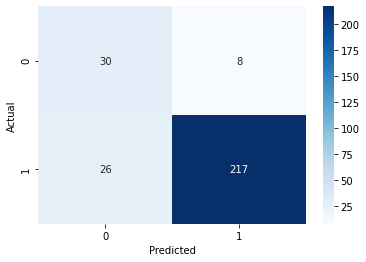

In [79]:
# Test Confusion Matrix
sns.heatmap(cm_test, annot=True,fmt="d",cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [80]:
neg_class_prob_sorted = (mnb.feature_log_prob_[0, :]).argsort()
pos_class_prob_sorted = (mnb.feature_log_prob_[1, :]).argsort()

In [81]:
features=vectorizer_tfidf.get_feature_names()+vectorizer_tfidf_rh.get_feature_names()+vectorizer_r.get_feature_names()+vectorizer_d.get_feature_names()+vectorizer_c.get_feature_names()+vectorizer_de.get_feature_names()+vectorizer_b.get_feature_names()+vectorizer_pn.get_feature_names()+['Final_Price_after_Discount']

In [82]:
neg_class_features = np.take(features, neg_class_prob_sorted[:20])
pos_class_features = np.take(features, pos_class_prob_sorted[:20])

In [83]:
print("The top 20 features from the positive class are :\n")
print(neg_class_features)
    
print("\nThe top 20 features from the negative class are :\n")
print(pos_class_features)

The top 20 features from the positive class are :

['love' 'fact'
 'harbor_breeze_bayou_creek_56_bronze_indoor_ceiling_fan_light_kit_remote_5_blade'
 'harbor_breeze_barnstaple_bay_52_white_indoor_ceiling_fan_light_kit_5_blade'
 'far' 'feature' 'perfect' 'stars' 'finish' 'fits' 'flow' 'flush'
 'perfectly' 'four'
 'harbor_breeze_barnstaple_bay_52_brushed_nickel_indoor_ceiling_fan_light_kit_5_blade'
 'spare' 'functions' 'furniture' 'garage' 'pretty']

The top 20 features from the negative class are :

['ceiling_fans' 'ceiling_fans_' 'hampton_bay' 'ceiling_fans_with_lights'
 'horrible' 'poor' 'horrible' 'hum' 'ceiling_fans_without_lights'
 '_accessories' 'ceiling_fans' 'brand_not_mentioned'
 'fanimation_studio_collection' 'told' 'full' 'limited' 'canopy' 'kind'
 'dont' 'manual']


In [85]:
# Summarizing the Data
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Alpha","Train-AUC", "Test-AUC"]
x.add_row(["Bag of Words", "Naive Bayes", .5, .982, .935])
x.add_row(["TFIDF", "Naive Bayes", .1, .989, .939])
print(x)

+--------------+-------------+-------+-----------+----------+
|  Vectorizer  |    Model    | Alpha | Train-AUC | Test-AUC |
+--------------+-------------+-------+-----------+----------+
| Bag of Words | Naive Bayes |  0.5  |   0.982   |  0.935   |
|    TFIDF     | Naive Bayes |  0.1  |   0.989   |  0.939   |
+--------------+-------------+-------+-----------+----------+
